<a href="https://colab.research.google.com/github/Joppenheimer1/NBA-Playoff-Simulator/blob/main/Eastern_Conference_Semi_Finals_2025_NBA_Playoff_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#only if necessary
pip install requests

In [ ]:
import requests

url = "https://api-nba-v1.p.rapidapi.com/teams"

headers = {
    "x-rapidapi-host": "api-nba-v1.p.rapidapi.com",
    "x-rapidapi-key": "" #your api key from rapid api
}

response = requests.get(url, headers=headers)
teams = response.json()['response']

for team in teams:
    print(f"Team: {team['name']}, ID: {team['id']}")


Team: Atlanta Hawks, ID: 1
Team: Boston Celtics, ID: 2
Team: Brisbane Bullets, ID: 3
Team: Brooklyn Nets, ID: 4
Team: Charlotte Hornets, ID: 5
Team: Chicago Bulls, ID: 6
Team: Cleveland Cavaliers, ID: 7
Team: Dallas Mavericks, ID: 8
Team: Denver Nuggets, ID: 9
Team: Detroit Pistons, ID: 10
Team: Golden State Warriors, ID: 11
Team: Guangzhou Long-Lions, ID: 12
Team: Haifa Maccabi Haifa, ID: 13
Team: Houston Rockets, ID: 14
Team: Indiana Pacers, ID: 15
Team: LA Clippers, ID: 16
Team: Los Angeles Lakers, ID: 17
Team: Melbourne United, ID: 18
Team: Memphis Grizzlies, ID: 19
Team: Miami Heat, ID: 20
Team: Milwaukee Bucks, ID: 21
Team: Minnesota Timberwolves, ID: 22
Team: New Orleans Pelicans, ID: 23
Team: New York Knicks, ID: 24
Team: Oklahoma City Thunder, ID: 25
Team: Orlando Magic, ID: 26
Team: Philadelphia 76ers, ID: 27
Team: Phoenix Suns, ID: 28
Team: Portland Trail Blazers, ID: 29
Team: Sacramento Kings, ID: 30
Team: San Antonio Spurs, ID: 31
Team: Shanghai Sharks, ID: 32
Team: Sydney

In [ ]:
import json

url_celtics = "https://api-nba-v1.p.rapidapi.com/teams/statistics?id=2&season=2024"
url_knicks = "https://api-nba-v1.p.rapidapi.com/teams/statistics?id=20&season=2024"

response_celtics = requests.get(url_celtics, headers=headers)
response_knicks = requests.get(url_knicks, headers=headers)

data_celtics = response_celtics.json()['response'][0]
data_knicks = response_knicks.json()['response'][0]


def process_team_stats(data, team_name):
    fgp = float(data['fgp'])
    tpp = float(data['tpp'])
    ftp = float(data['ftp'])
    fga = float(data['fga'])
    tpa = float(data['tpa'])
    fta = float(data['fta'])

    two_pa = fga - tpa
    # Assume 60% layups, 40% midrange - reasonable assumption
    layup_attempts = two_pa * 0.6
    midrange_attempts = two_pa * 0.4

    print(f"\n{team_name} Stats (2024 season):")
    print(f"FG%: {fgp}%")
    print(f"3P%: {tpp}%")
    print(f"FT%: {ftp}%")
    print(f"FGA: {fga}")
    print(f"3PA: {tpa}")
    print(f"2PA: {two_pa}")
    print(f"Estimated Layup Attempts: {layup_attempts}")
    print(f"Estimated Midrange Attempts: {midrange_attempts}")
    print(f"FTA: {fta}")

    return {
        'fgp': fgp,
        'tpp': tpp,
        'ftp': ftp,
        'fga': fga,
        'tpa': tpa,
        'two_pa': two_pa,
        'layup_attempts': layup_attempts,
        'midrange_attempts': midrange_attempts,
        'fta': fta
    }

celtics_stats = process_team_stats(data_celtics, "Celtics")
knicks_stats = process_team_stats(data_knicks, "Knicks")


Celtics Stats (2024 season):
FG%: 61.5%
3P%: 36.9%
FT%: 80.3%
FGA: 8148.0
3PA: 4326.0
2PA: 3822.0
Estimated Layup Attempts: 2293.2
Estimated Midrange Attempts: 1528.8000000000002
FTA: 1784.0

Knicks Stats (2024 season):
FG%: 63.2%
3P%: 36.8%
FT%: 78.5%
FGA: 8095.0
3PA: 3501.0
2PA: 4594.0
Estimated Layup Attempts: 2756.4
Estimated Midrange Attempts: 1837.6000000000001
FTA: 1865.0


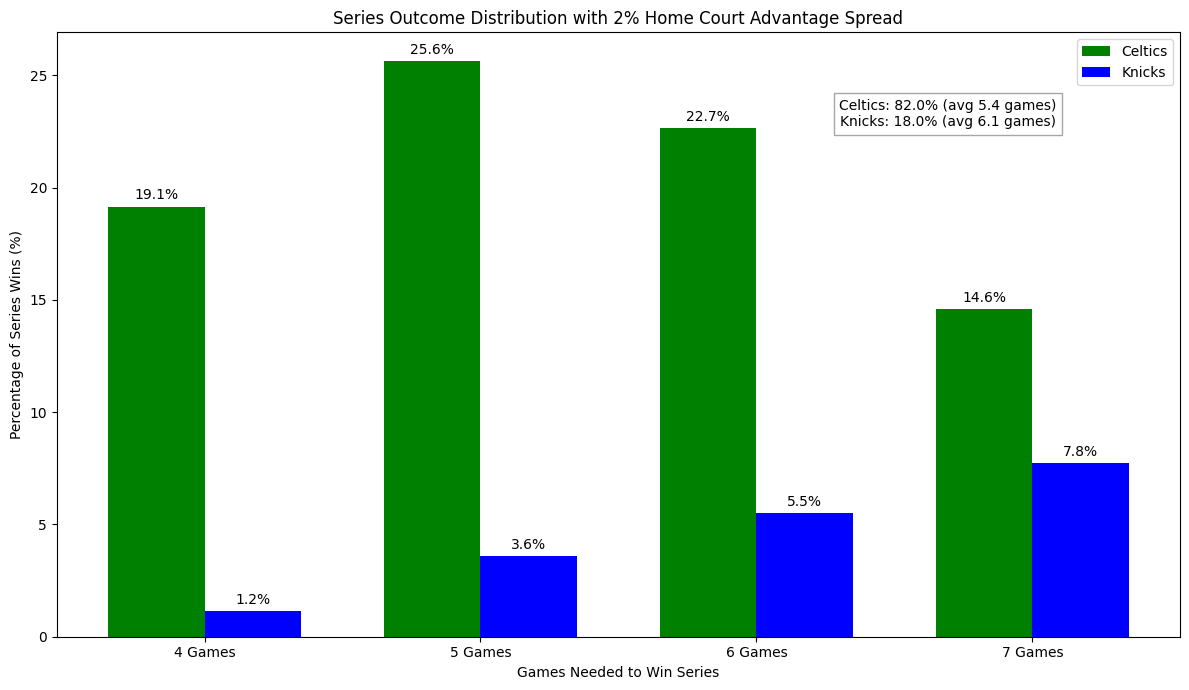

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Team statistics (2024 season data provided above)

team_stats = { #per season, divide by 82 to get per game, percentage does not need to be adjusted
    'Celtics': {
        'fg_pct': 0.615,
        'tp_pct': 0.369,
        'ft_pct': 0.803,
        'fga': 8148 / 82,
        'tpa': 4326 / 82,
        'layup_attempts': 2293.2 / 82.0,
        'midrange_attempts': 1528.8 / 82.0,
        'fta': 1784 / 82
    },
    'Knicks': {
        'fg_pct': 0.632,
        'tp_pct': 0.368,
        'ft_pct': 0.785,
        'fga': 8095 / 82,
        'tpa': 3501 / 82,
        'layup_attempts': 2756.4 / 82.0,
        'midrange_attempts': 1837.6 / 82.0,
        'fta': 1865 / 82
    }
}

# Parameters - can be tweaked to your liking
momentum_cap = 0.1  # maximum momentum boost/penalty (+/-10%) for consecutive makes/misses
home_court_advantage = 0.01  # +1% boost for home team, -1% penalty for away team - giving a 2% spread
foul_chance = 0.15  # chance a shot results in a foul - varies for layups, midrange, and threes
and_one_chance = 0.30  # chance that a fouled make is an "and-one" - varies if shot was made (account for rigged refs lol)


def simulate_game(home_team, away_team):
    # Enforce momentum cap
    momentum = {home_team: home_court_advantage, away_team: -home_court_advantage}
    momentum[home_team] = np.clip(momentum[home_team], -momentum_cap, momentum_cap)
    momentum[away_team] = np.clip(momentum[away_team], -momentum_cap, momentum_cap)

      # Randomize total possessions per team (mean 100, std 5 for standard NBA pace)
    total_possessions = {
        home_team: int(np.random.normal(100, 5)),
        away_team: int(np.random.normal(100, 5))
    }

    # Randomize turnovers per team (mean=13, std=sqrt(2)) - these will not end up in a shot attempt
    turnovers = {
        home_team: int(np.random.normal(13, 2)),
        away_team: int(np.random.normal(13, 2))
    }

    # Ensure turnovers aren’t negative or exceeding total possessions
    turnovers[home_team] = max(0, min(turnovers[home_team], total_possessions[home_team]))
    turnovers[away_team] = max(0, min(turnovers[away_team], total_possessions[away_team]))

    # Remaining possessions are possessions ending in a shot
    possessions = {
        home_team: total_possessions[home_team] - turnovers[home_team],
        away_team: total_possessions[away_team] - turnovers[away_team]
    }

    # Get each teams stats
    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]

    # Covariance matrix (negative correlation between shot attempts)
    # Example values: More three-pointers means fewer layups and midranges
    correlation_matrix = np.array([
        [1.0, -0.3, -0.4],  # layups: correlated with midrange and 3s negatively
        [-0.3, 1.0, -0.5],  # midrange: correlated with layups and 3s negatively
        [-0.4, -0.5, 1.0]   # 3-pointers: correlated with layups and midrange negatively
    ])

    # Simulate shot attempts (layups, midranges, 3pt shots) using multivariate normal distribution
    points = {home_team: 0, away_team: 0}  # Track points for both teams

    for team, stats in zip([home_team, away_team], [home_stats, away_stats]):
        team_possessions = possessions[team]

        # Mean shot attempts for each type (lambda for Poisson approximation)
        mean_shots = np.array([stats['layup_attempts'], stats['midrange_attempts'], stats['tpa']])

        # Simulate correlated shot attempts
        shots = np.random.multivariate_normal(mean_shots, correlation_matrix * 2, size=1).flatten()

        # Ensure non-negative shot attempts
        shots = np.maximum(shots, 0)

        layups, midrange, threes = int(shots[0]), int(shots[1]), int(shots[2])

        # Simulate layup attempts
        for _ in range(layups):
            adj_pct = np.clip(stats['fg_pct'] + momentum[team], 0, 1)
            shot_made = np.random.rand() < adj_pct

            if shot_made:
                points[team] += 2
                fouled = np.random.rand() < foul_chance - 0.075 #less likely to get foul call if shot made
                if fouled and np.random.rand() < and_one_chance:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1
            else:
                fouled = np.random.rand() < foul_chance
                if fouled:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1

        # Simulate midrange attempts
        for _ in range(midrange):
            adj_pct = np.clip(stats['fg_pct'] + momentum[team], 0, 1)  # midrange slightly lower % due to distance
            shot_made = np.random.rand() < adj_pct


            if shot_made:
                points[team] += 2
                fouled = np.random.rand() < foul_chance - 0.075 #less likely to get foul call if shot made
                if fouled and np.random.rand() < and_one_chance:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1
            else:
                fouled = np.random.rand() < foul_chance - 0.03  # Slightly lower foul chance for midrange
                if fouled:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1

        # Simulate 3pt attempts
        for _ in range(threes):
            adj_pct = np.clip(stats['fg_pct'] + momentum[team], 0, 1)
            shot_made = np.random.rand() < adj_pct


            if shot_made:
                points[team] += 3
                fouled = np.random.rand() < foul_chance - 0.125 #less likely to get foul call if shot made on 3
                if fouled and np.random.rand() < and_one_chance:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1
            else:
                fouled = np.random.rand() < foul_chance - 0.075  # Slightly lower foul chance for 3-pointers
                if fouled:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1

    # Determine winner
    winner = home_team if points[home_team] > points[away_team] else away_team

    return winner

# Function to simulate the series
def simulate_series(home_team, away_team):
    wins = {home_team: 0, away_team: 0}
    game_count = 0

    # Simulate a best-of-seven series
    while wins[home_team] < 4 and wins[away_team] < 4:
        game_winner = simulate_game(home_team, away_team)
        wins[game_winner] += 1
        game_count += 1

    # Return the winner and the total number of games played
    series_winner = home_team if wins[home_team] == 4 else away_team
    return series_winner, game_count


def monte_carlo_simulations(num_simulations=10000):
    series_outcomes = {
        'Celtics': {4: 0, 5: 0, 6: 0, 7: 0},
        'Knicks': {4: 0, 5: 0, 6: 0, 7: 0}
    }

    for _ in range(num_simulations):
        winner, num_games = simulate_series('Celtics', 'Knicks')
        if num_games in [4, 5, 6, 7]:
            series_outcomes[winner][num_games] += 1

    percentages = {
        team: {games: (series_outcomes[team][games] / num_simulations) * 100 for games in [4, 5, 6, 7]}
        for team in ['Celtics', 'Knicks']
    }

        # Calculate total percentage of wins per team and weighted average of how long
    total_celtics = sum(percentages['Celtics'].values())
    if total_celtics > 0:
        average_celtics = sum(g * (percentages['Celtics'][g] / total_celtics) for g in [4,5,6,7])
    else:
        average_celtics = 0

    total_knicks = sum(percentages['Knicks'].values())
    if total_knicks > 0:
        average_knicks = sum(g * (percentages['Knicks'][g] / total_knicks) for g in [4,5,6,7])
    else:
        average_knicks = 0


    # Create summary text string
    overall_summary = (
        f"Celtics: {total_celtics:.1f}% (avg {average_celtics:.1f} games)\n"
        f"Knicks: {total_knicks:.1f}% (avg {average_knicks:.1f} games)"
    )

    # Plotting
    labels = ['4 Games', '5 Games', '6 Games', '7 Games']
    celtics_percentages = [percentages['Celtics'][g] for g in [4, 5, 6, 7]]
    knicks_percentages = [percentages['Knicks'][g] for g in [4, 5, 6, 7]]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, celtics_percentages, width, label='Celtics', color='green')
    rects2 = ax.bar(x + width/2, knicks_percentages, width, label='Knicks', color='blue')

    ax.set_ylabel('Percentage of Series Wins (%)')
    ax.set_xlabel('Games Needed to Win Series')
    ax.set_title('Series Outcome Distribution with 2% Home Court Advantage Spread')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right')

    # New summary box at top left
    ax.text(0.89, 0.89, overall_summary, transform=ax.transAxes,
        fontsize=10, va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))


    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

# Run the simulation
monte_carlo_simulations(10000)


In [ ]:
#new project - lets try Cavs-Pacers with same assumptions and 2% spread

In [ ]:
import requests
import json

headers = {
    "x-rapidapi-host": "api-nba-v1.p.rapidapi.com",
    "x-rapidapi-key": "0f4c8ca0b1msh42938db49e4c8fbp194f83jsnef60db190139"
}

url_cavs = "https://api-nba-v1.p.rapidapi.com/teams/statistics?id=7&season=2024"
url_pacers = "https://api-nba-v1.p.rapidapi.com/teams/statistics?id=15&season=2024"

response_cavs = requests.get(url_cavs, headers=headers)
response_pacers = requests.get(url_pacers, headers=headers)

data_cavs = response_cavs.json()['response'][0]
data_pacers = response_pacers.json()['response'][0]


def process_team_stats(data, team_name):
    fgp = float(data['fgp'])
    tpp = float(data['tpp'])
    ftp = float(data['ftp'])
    fga = float(data['fga'])
    tpa = float(data['tpa'])
    fta = float(data['fta'])

    two_pa = fga - tpa
    # Assume 60% layups, 40% midrange - reasonable assumption
    layup_attempts = two_pa * 0.6
    midrange_attempts = two_pa * 0.4

    print(f"\n{team_name} Stats (2024 season):")
    print(f"FG%: {fgp}%")
    print(f"3P%: {tpp}%")
    print(f"FT%: {ftp}%")
    print(f"FGA: {fga}")
    print(f"3PA: {tpa}")
    print(f"2PA: {two_pa}")
    print(f"Estimated Layup Attempts: {layup_attempts}")
    print(f"Estimated Midrange Attempts: {midrange_attempts}")
    print(f"FTA: {fta}")

    return {
        'fgp': fgp,
        'tpp': tpp,
        'ftp': ftp,
        'fga': fga,
        'tpa': tpa,
        'two_pa': two_pa,
        'layup_attempts': layup_attempts,
        'midrange_attempts': midrange_attempts,
        'fta': fta
    }

cavs_stats = process_team_stats(data_cavs, "Cavs")
pacers_stats = process_team_stats(data_pacers, "Pacers")


Cavs Stats (2024 season):
FG%: 63.5%
3P%: 38.1%
FT%: 77.4%
FGA: 8260.0
3PA: 3779.0
2PA: 4481.0
Estimated Layup Attempts: 2688.6
Estimated Midrange Attempts: 1792.4
FTA: 2007.0

Pacers Stats (2024 season):
FG%: 63.9%
3P%: 37.0%
FT%: 79.1%
FGA: 8211.0
3PA: 3301.0
2PA: 4910.0
Estimated Layup Attempts: 2946.0
Estimated Midrange Attempts: 1964.0
FTA: 1983.0


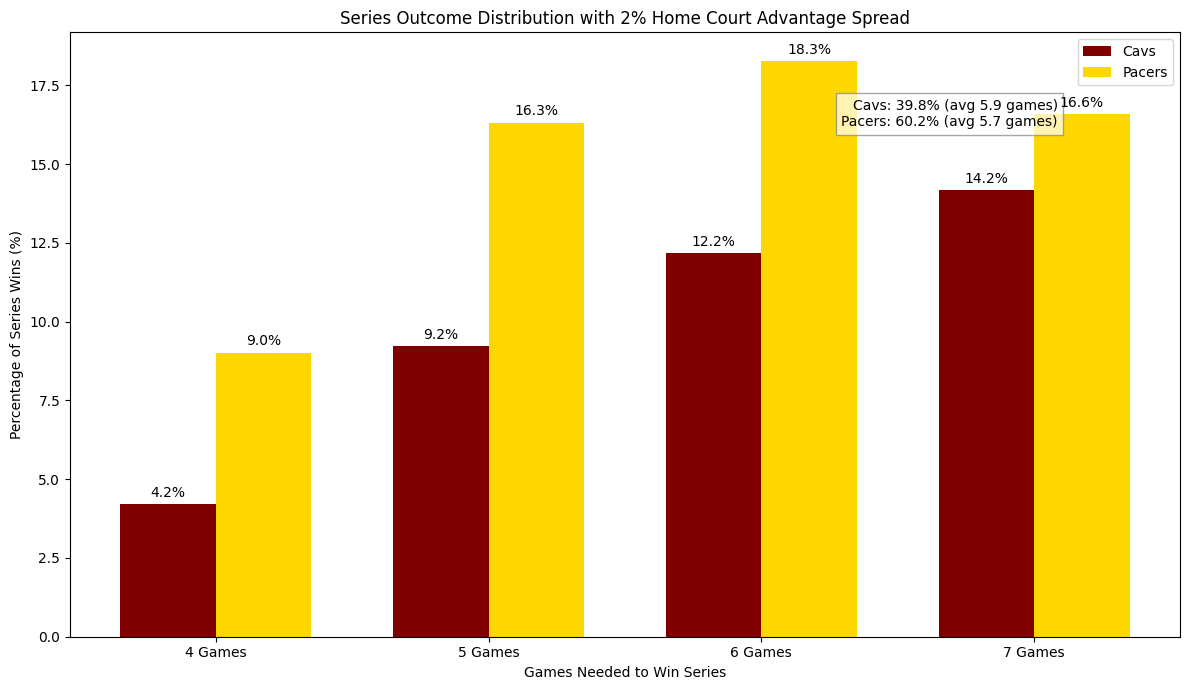

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Team statistics (2024 season data provided above)

team_stats = { #per season, divide by 82 to get per game, percentage does not need to be adjusted
    'Cavs': {
        'fg_pct': 0.635,
        'tp_pct': 0.381,
        'ft_pct': 0.774,
        'fga': 8260 / 82,
        'tpa': 3379 / 82,
        'layup_attempts': 2688.6 / 82.0,
        'midrange_attempts': 1792.4 / 82.0,
        'fta': 2007 / 82
    },
    'Pacers': {
        'fg_pct': 0.639,
        'tp_pct': 0.37,
        'ft_pct': 0.791,
        'fga': 8211 / 82,
        'tpa': 3301 / 82,
        'layup_attempts': 2946.0 / 82.0,
        'midrange_attempts': 1964.0 / 82.0,
        'fta': 1983 / 82
    }
}

# Parameters - can be tweaked to your liking
momentum_cap = 0.1  # maximum momentum boost/penalty (+/-10%) for consecutive makes/misses
home_court_advantage = 0.01  # +1% boost for home team, -1% penalty for away team - giving a 2% spread
foul_chance = 0.15  # chance a shot results in a foul - varies for layups, midrange, and threes
and_one_chance = 0.30  # chance that a fouled make is an "and-one" - varies if shot was made (account for rigged refs lol)


def simulate_game(home_team, away_team):
    # Enforce momentum cap
    momentum = {home_team: home_court_advantage, away_team: -home_court_advantage}
    momentum[home_team] = np.clip(momentum[home_team], -momentum_cap, momentum_cap)
    momentum[away_team] = np.clip(momentum[away_team], -momentum_cap, momentum_cap)

      # Randomize total possessions per team (mean 100, std 5 for standard NBA pace)
    total_possessions = {
        home_team: int(np.random.normal(100, 5)),
        away_team: int(np.random.normal(100, 5))
    }

    # Randomize turnovers per team (mean=13, std=sqrt(2)) - these will not end up in a shot attempt
    turnovers = {
        home_team: int(np.random.normal(13, 2)),
        away_team: int(np.random.normal(13, 2))
    }

    # Ensure turnovers aren’t negative or exceeding total possessions
    turnovers[home_team] = max(0, min(turnovers[home_team], total_possessions[home_team]))
    turnovers[away_team] = max(0, min(turnovers[away_team], total_possessions[away_team]))

    # Remaining possessions are possessions ending in a shot
    possessions = {
        home_team: total_possessions[home_team] - turnovers[home_team],
        away_team: total_possessions[away_team] - turnovers[away_team]
    }

    # Get each teams stats
    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]

    # Covariance matrix (negative correlation between shot attempts)
    # Example values: More three-pointers means fewer layups and midranges
    correlation_matrix = np.array([
        [1.0, -0.3, -0.4],  # layups: correlated with midrange and 3s negatively
        [-0.3, 1.0, -0.5],  # midrange: correlated with layups and 3s negatively
        [-0.4, -0.5, 1.0]   # 3-pointers: correlated with layups and midrange negatively
    ])

    # Simulate shot attempts (layups, midranges, 3pt shots) using multivariate normal distribution
    points = {home_team: 0, away_team: 0}  # Track points for both teams

    for team, stats in zip([home_team, away_team], [home_stats, away_stats]):
        team_possessions = possessions[team]

        # Mean shot attempts for each type (lambda for Poisson approximation)
        mean_shots = np.array([stats['layup_attempts'], stats['midrange_attempts'], stats['tpa']])

        # Simulate correlated shot attempts
        shots = np.random.multivariate_normal(mean_shots, correlation_matrix * 2, size=1).flatten()

        # Ensure non-negative shot attempts
        shots = np.maximum(shots, 0)

        layups, midrange, threes = int(shots[0]), int(shots[1]), int(shots[2])

        # Simulate layup attempts
        for _ in range(layups):
            adj_pct = np.clip(stats['fg_pct'] + momentum[team], 0, 1)
            shot_made = np.random.rand() < adj_pct

            if shot_made:
                points[team] += 2
                fouled = np.random.rand() < foul_chance - 0.075 #less likely to get foul call if shot made
                if fouled and np.random.rand() < and_one_chance:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1
            else:
                fouled = np.random.rand() < foul_chance
                if fouled:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1

        # Simulate midrange attempts
        for _ in range(midrange):
            adj_pct = np.clip(stats['fg_pct'] + momentum[team], 0, 1)  # midrange slightly lower % due to distance
            shot_made = np.random.rand() < adj_pct


            if shot_made:
                points[team] += 2
                fouled = np.random.rand() < foul_chance - 0.075 #less likely to get foul call if shot made
                if fouled and np.random.rand() < and_one_chance:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1
            else:
                fouled = np.random.rand() < foul_chance - 0.03  # Slightly lower foul chance for midrange
                if fouled:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1

        # Simulate 3pt attempts
        for _ in range(threes):
            adj_pct = np.clip(stats['fg_pct'] + momentum[team], 0, 1)
            shot_made = np.random.rand() < adj_pct


            if shot_made:
                points[team] += 3
                fouled = np.random.rand() < foul_chance - 0.125 #less likely to get foul call if shot made on 3
                if fouled and np.random.rand() < and_one_chance:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1
            else:
                fouled = np.random.rand() < foul_chance - 0.075  # Slightly lower foul chance for 3-pointers
                if fouled:
                    if np.random.rand() < stats['ft_pct']:  # No momentum for free throws
                        points[team] += 1

    # Determine winner
    winner = home_team if points[home_team] > points[away_team] else away_team

    return winner

# Function to simulate the series
def simulate_series(home_team, away_team):
    wins = {home_team: 0, away_team: 0}
    game_count = 0

    # Simulate a best-of-seven series
    while wins[home_team] < 4 and wins[away_team] < 4:
        game_winner = simulate_game(home_team, away_team)
        wins[game_winner] += 1
        game_count += 1

    # Return the winner and the total number of games played
    series_winner = home_team if wins[home_team] == 4 else away_team
    return series_winner, game_count


def monte_carlo_simulations(num_simulations=10000):
    series_outcomes = {
        'Cavs': {4: 0, 5: 0, 6: 0, 7: 0},
        'Pacers': {4: 0, 5: 0, 6: 0, 7: 0}
    }

    for _ in range(num_simulations):
        winner, num_games = simulate_series('Cavs', 'Pacers')
        if num_games in [4, 5, 6, 7]:
            series_outcomes[winner][num_games] += 1

    percentages = {
        team: {games: (series_outcomes[team][games] / num_simulations) * 100 for games in [4, 5, 6, 7]}
        for team in ['Cavs', 'Pacers']
    }

        # Calculate total percentage of wins per team and weighted average of how long
    total_celtics = sum(percentages['Cavs'].values())
    if total_celtics > 0:
        average_celtics = sum(g * (percentages['Cavs'][g] / total_celtics) for g in [4,5,6,7])
    else:
        average_celtics = 0

    total_knicks = sum(percentages['Pacers'].values())
    if total_knicks > 0:
        average_knicks = sum(g * (percentages['Pacers'][g] / total_knicks) for g in [4,5,6,7])
    else:
        average_knicks = 0


    # Create summary text string
    overall_summary = (
        f"Cavs: {total_celtics:.1f}% (avg {average_celtics:.1f} games)\n"
        f"Pacers: {total_knicks:.1f}% (avg {average_knicks:.1f} games)"
    )

    # Plotting
    labels = ['4 Games', '5 Games', '6 Games', '7 Games']
    celtics_percentages = [percentages['Cavs'][g] for g in [4, 5, 6, 7]]
    knicks_percentages = [percentages['Pacers'][g] for g in [4, 5, 6, 7]]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, celtics_percentages, width, label='Cavs', color='maroon')
    rects2 = ax.bar(x + width/2, knicks_percentages, width, label='Pacers', color='gold')

    ax.set_ylabel('Percentage of Series Wins (%)')
    ax.set_xlabel('Games Needed to Win Series')
    ax.set_title('Series Outcome Distribution with 2% Home Court Advantage Spread')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right')

    # New summary box at top left
    ax.text(0.89, 0.89, overall_summary, transform=ax.transAxes,
        fontsize=10, va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))


    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

# Run the simulation
monte_carlo_simulations(10000)
